In [1]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
import os

import rasterio
# import shapely.geometry
import geojson

from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import spec_defs

# from garuda.ops import obb_to_aa

import torch
import torchvision.transforms as transforms
if torch.cuda.is_available():
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU")

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True, torch_dtype='auto').eval().to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

04/18/2025 10:31:40 - INFO - numexpr.utils -   Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
04/18/2025 10:31:40 - INFO - numexpr.utils -   NumExpr defaulting to 16 threads.


In [2]:
def box_area(box): # box in [xmin, ymin, xmax, ymax] format
    return (box[2] - box[0]) * (box[3] - box[1]) # calculating area

def convert_to_xyxy(box, h_im, w_im): # box: [label, x_center, y_center, width, height], YOLO aa format
    x_center, y_center, width, height = box[1], box[2], box[3], box[4]
    x_min = (x_center - width / 2) * w_im # scaling to image size
    y_min = (y_center - height / 2) * h_im
    x_max = (x_center + width / 2) * w_im
    y_max = (y_center + height / 2) * h_im
    return [x_min, y_min, x_max, y_max], box[0]

def calc_iou(box_a, box_b):
    box_a = np.array(box_a)
    box_b = np.array(box_b)
    
    area_a = box_area(box_a)
    area_b = box_area(box_b)
    
    top_left = np.maximum(box_a[:2], box_b[:2]) # finding overlap
    bottom_right = np.minimum(box_a[2:], box_b[2:])
    area_inter = np.prod(np.clip(bottom_right - top_left, a_min=0, a_max=None))
    
    return abs(area_inter) / (abs(area_a) + abs(area_b) - abs(area_inter))

In [3]:
def match_boxes(pred_boxes, gt_boxes, iou_threshold):
    matches =[]
    gt_kilns = [0]*len(gt_boxes)
    for pred in pred_boxes:
        for i, gt in enumerate(gt_boxes): # iterating over gt boxes
            iou_score = calc_iou(pred, gt) # calc iou score
            if iou_score >= iou_threshold: # checking for overlap
                matches.append((pred, gt_boxes[i])) # mark as correct prediction
                gt_kilns[i] = 1
    kilns_found = 0
    for i in gt_kilns:
        if i==1:
            kilns_found += 1
    return matches, kilns_found, gt_kilns

In [4]:
from sahi import slicing

In [5]:
image_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/swinir_data/lucknow_airshed_most_15/images"
label_path = "/home/nupoor.assudani/cs299_main/lucknow_airshed_most_15_aa_labels/"
base_names = ['8988385_3137890', '8999392_3085607', '9021406_3113124', '9029661_3107621',
               '9035164_3091111', '8988385_3140642', '9002144_3118628', '9021406_3115876',
               '9032413_3107621', '9037916_3088359', '8999392_3082855', '9004895_3118628',
               '9024157_3085607', '9035164_3088359', '9040668_3088359']
img_paths = []
lab_paths = []
for i in range(15):
    img_paths.append((f'{image_path}/{base_names[i]}.png'))
    lab_paths.append((f'{label_path}/{base_names[i]}.txt'))

In [6]:
import re

In [7]:
iou_th = 0.5

In [8]:
text_prompt = "<CAPTION_TO_PHRASE_GROUNDING>oval brick kilns, circular brick kilns, rectangular brick kilns, chimneys"

In [9]:
from PIL import ImageEnhance

In [10]:
ground_kilns = 0
correct_predictions = 0
num_kilns_found = 0
total_predictions = 0
for j in range(15):
    x = slicing.slice_image(
        image=img_paths[j],
        slice_height=640,
        slice_width=640,
        overlap_height_ratio=0.2,
        overlap_width_ratio=0.2,
        )
    
    original_image = Image.open(img_paths[j])
    output_bboxes = []
    output_labels = []
    for i in range(len(x.sliced_image_list)):
        im = x.sliced_image_list[i]
        img = Image.fromarray(im.image)
        # img.convert('RGB') ##
        # con_image = ImageEnhance.Contrast(img) ##
        # con_image = con_image.enhance(1.5) ##
        inputs = processor(text = text_prompt, images=img, return_tensors="pt").to(device, torch_dtype) # giving input to model
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=4096,
            num_beams=3,
            do_sample=False
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0] # model output
        od_parsed = processor.post_process_generation(generated_text, task="CAPTION_TO_PHRASE_GROUNDING", image_size=(img.width, img.height))
        print(od_parsed)
        model_op = od_parsed["CAPTION_TO_PHRASE_GROUNDING"] # relevant portion of model output
        op_bboxes =[]
        op_labels =[]
        if type(model_op)!=str:
            op_bboxes = model_op['bboxes'] # bounding boxes in [xmin, ymin, xmax, ymax] format
            op_labels = model_op['labels'] #labels
        else:
            pattern = r'([a-zA-Z ]+)?(?:<loc_(\d+)><loc_(\d+)><loc_(\d+)><loc_(\d+)>)'
            matches = re.findall(pattern, model_op)
            print(matches)
            for match in matches:
                label, x1, y1, x2, y2 = match  # Default to "unlabeled" if no label is found
                x1 = int((int(x1) / 1000) * 640)
                y1 = int((int(y1) / 1000) * 640)
                x2 = int((int(x2) / 1000) * 640)
                y2 = int((int(y2) / 1000) * 640)

                op_labels.append(label)
                op_bboxes.append([x1, y1, x2, y2])

        filtered_bboxes = []
        filtered_labels = []
        if op_bboxes!=[] and op_labels!=[]:
            for bbox, label in zip(op_bboxes, op_labels):
                if label != "satellite image":
                    filtered_bboxes.append(bbox)
                    filtered_labels.append(label)
        print(filtered_bboxes)
        print(filtered_labels)
        for bbox in filtered_bboxes:
            ofs_x, ofs_y = im.starting_pixel
            x1 = bbox[0] + ofs_x
            y1 = bbox[1] + ofs_y
            x2 = bbox[2] + ofs_x
            y2 = bbox[3] + ofs_y
            new_bb = [x1, y1, x2, y2]
            output_bboxes.append(new_bb)
        output_labels.extend(filtered_labels)
    with open(lab_paths[j]):
        gt = np.loadtxt(lab_paths[j], ndmin=2)
    gt_bboxes = []
    gt_labels = []
    for gt_kiln in gt:
        gt_i, gt_lab = convert_to_xyxy(gt_kiln, 2560, 2560)
        gt_bboxes.append(gt_i)
        gt_labels.append(gt_lab)

    # pred_bboxes = merge_boxes(output_bboxes) ### add code to give merged predictions
    if len(gt_bboxes) != 0:
        matched_pairs, kilns_found, gt_kilns_found = match_boxes(output_bboxes, gt_bboxes, iou_th)
    else:
        matched_pairs = []
        kilns_found = 0
    gt_num = len(gt_bboxes)
    pred_num = len(output_bboxes)
    num_corr = len(matched_pairs)

    predictions_that_matched = []
    for i in range(len(matched_pairs)):
        predictions_that_matched.append(matched_pairs[i][0])

    fig, ax = plt.subplots(figsize=(10, 5))  # Single plot
    ax.imshow(original_image)
    for i in range(len(gt_kilns_found)):
        if gt_kilns_found[i]==1:
            x1, y1, x2, y2 = gt_bboxes[i]
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
            # if gt_labels:
            #     ax.text(x1, y1, gt_labels[i], color='white', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))

        
    for idx, bbox in enumerate(predictions_that_matched):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # # for idx, bbox in enumerate(pred_bboxes):
    # #     x1, y1, x2, y2 = bbox
    # #     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    # #     ax.add_patch(rect)

    ax.axis("off")
    plt.title("Ground Truth (Blue), Predictions (Red)")
    plt.show()

        # prec = num_corr/pred_num
        # rec = num_corr/gt_num
        # f1 = 2/((1/prec)+(1/rec))
    print("number of ground truth kilns =", gt_num)
    print("predicted number of kilns =", pred_num)
    print("number of predictions that were correct =", num_corr)
    print("number of ground truth kilns found by the predictions =", kilns_found)
    ground_kilns += gt_num
    correct_predictions += num_corr
    num_kilns_found += kilns_found
    total_predictions += pred_num

print('End of processing for this prompt')
if correct_predictions!=0:
    prec = correct_predictions/total_predictions
    print("Precision =", prec)
    rec = num_kilns_found/ground_kilns
    print("Recall =", rec)
    f1 = 2*prec*rec/(prec+rec)
    print("F1 score =", f1)

FileNotFoundError: No such file: '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/swinir_data/lucknow_airshed_most_15/images/8988385_3137890.png'

[[2.879999876022339, 2.240000009536743, 638.3999633789062, 637.760009765625], [450.8800048828125, 290.239990234375, 639.0399780273438, 437.44000244140625], [450.8800048828125, 290.239990234375, 639.6799926757812, 437.44000244140625], [419.5199890136719, 233.27999877929688, 437.44000244140625, 261.44000244140625]]
['oval brick kilns', 'circular brick kiln', 'rectangular brick kils', 'chimneys']
[[0.3199999928474426, 0.3199999928474426, 639.6799926757812, 639.6799926757812], [0.3199999928474426, 288.9599914550781, 176.3199920654297, 440.0], [0.9599999785423279, 0.3199999928474426, 639.6799926757812, 639.0399780273438], [0.3199999928474426, 288.9599914550781, 176.95999145507812, 440.0], [0.3199999928474426, 288.9599914550781, 175.67999267578125, 440.0], [0.3199999928474426, 288.9599914550781, 177.59999084472656, 440.0], [434.8800048828125, 0.3199999928474426, 522.5599975585938, 80.95999908447266]]
['oval brick kilns', 'circular brick kiln', 'circular bricks kilns', 'circular bricks kilns'

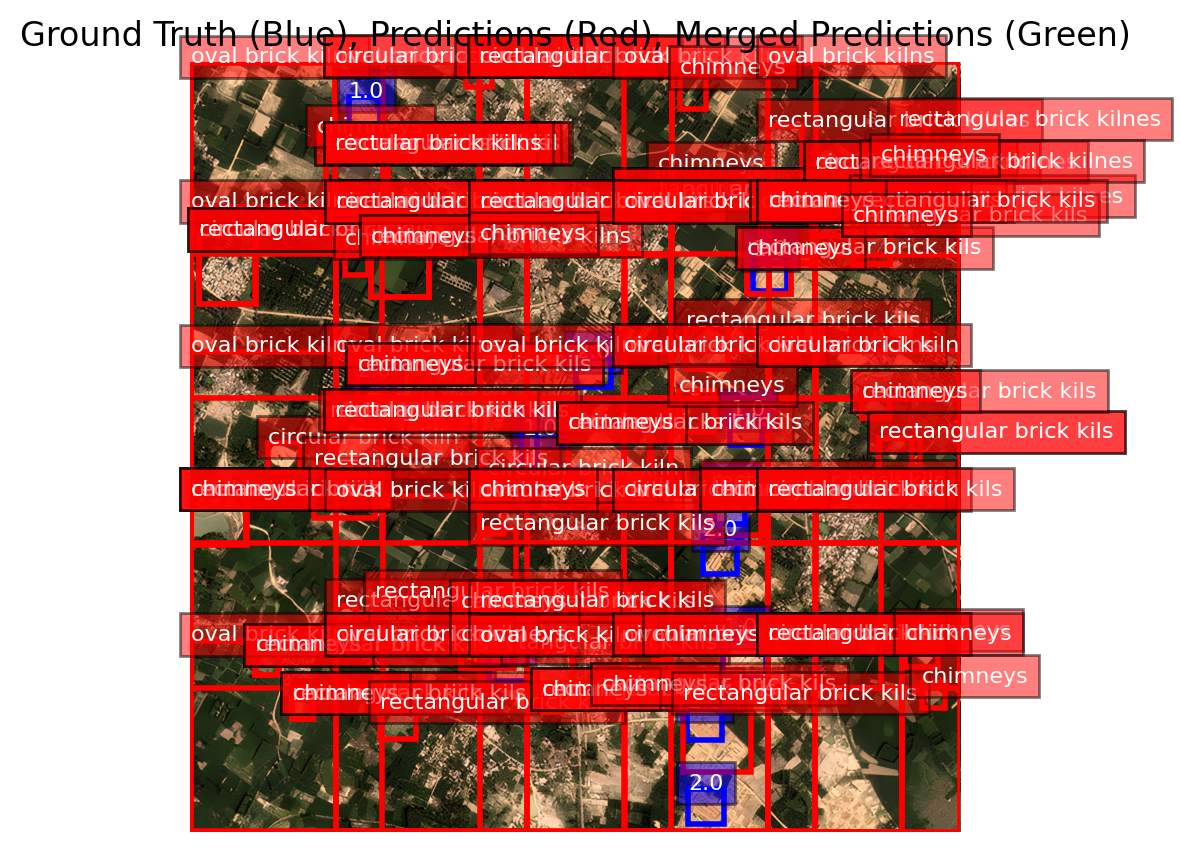

number of ground truth kilns = 12
predicted number of kilns = 134
number of kilns predicted correctly = 10


In [ ]:
# x = slicing.slice_image(
#     image=image_path,
#     slice_height=640,
#     slice_width=640,
#     overlap_height_ratio=0.25,
#     overlap_width_ratio=0.25,
# )
# original_image = Image.open(image_path)
# output_bboxes = []
# output_labels = []
# for i in range(len(x.sliced_image_list)):
#     im = x.sliced_image_list[i]
#     img = Image.fromarray(im.image)
#     inputs = processor(text = text_prompt, images=img, return_tensors="pt").to(device, torch_dtype) # giving input to model
#     generated_ids = model.generate(
#         input_ids=inputs["input_ids"],
#         pixel_values=inputs["pixel_values"],
#         max_new_tokens=4096,
#         num_beams=3,
#         do_sample=False
#     )
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0] # model output
#     od_parsed = processor.post_process_generation(generated_text, task="<CAPTION_TO_PHRASE_GROUNDING>", image_size=(img.width, img.height))
#     # print(od_parsed)
#     model_op = od_parsed["<CAPTION_TO_PHRASE_GROUNDING>"] # relevant portion of model output
#     op_bboxes = model_op['bboxes'] # bounding boxes in [xmin, ymin, xmax, ymax] format
#     op_labels = model_op['labels'] #labels
#     filtered_bboxes = []
#     filtered_labels = []
#     if op_bboxes!=[] and op_labels!=[]:
#         for bbox, label in zip(op_bboxes, op_labels):
#             if label != "satellite image":
#                 filtered_bboxes.append(bbox)
#                 filtered_labels.append(label)
#     print(filtered_bboxes)
#     print(filtered_labels)
#     for bbox in filtered_bboxes:
#         ofs_x, ofs_y = im.starting_pixel
#         x1 = bbox[0] + ofs_x
#         y1 = bbox[1] + ofs_y
#         x2 = bbox[2] + ofs_x
#         y2 = bbox[3] + ofs_y
#         new_bb = [x1, y1, x2, y2]
#         output_bboxes.append(new_bb)
#     output_labels.extend(filtered_labels)
# with open(label_path):
#     gt = np.loadtxt(label_path, ndmin=2)
# gt_bboxes = []
# gt_labels = []
# for gt_kiln in gt:
#     gt_i, gt_lab = convert_to_xyxy(gt_kiln, 2560, 2560)
#     gt_bboxes.append(gt_i)
#     gt_labels.append(gt_lab)

# # pred_bboxes = merge_boxes(output_bboxes) ### add code to give merged predictions


# fig, ax = plt.subplots(figsize=(10, 5))  # Single plot
# ax.imshow(original_image)
# for idx, bbox in enumerate(gt_bboxes):
#     x1, y1, x2, y2 = bbox
#     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='b', facecolor='none')
#     ax.add_patch(rect)
#     if gt_labels:
#         ax.text(x1, y1, gt_labels[idx], color='white', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))

    
# for idx, bbox in enumerate(output_bboxes):
#     x1, y1, x2, y2 = bbox
#     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     if output_labels:
#         ax.text(x1, y1, output_labels[idx], color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

# # for idx, bbox in enumerate(pred_bboxes):
# #     x1, y1, x2, y2 = bbox
# #     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
# #     ax.add_patch(rect)

# ax.axis("off")
# plt.title("Ground Truth (Blue), Predictions (Red), Merged Predictions (Green)")
# plt.show()

# if len(gt_bboxes) != 0:
#     matched_pairs, kilns_found, gt_kilns_found = match_boxes(output_bboxes, gt_bboxes, iou_th)
# else:
#     matched_pairs = []
#     kilns_found = 0
# gt_num = len(gt_bboxes)
# pred_num = len(output_bboxes)
# num_corr = len(matched_pairs)

#     # prec = num_corr/pred_num
#     # rec = num_corr/gt_num
#     # f1 = 2/((1/prec)+(1/rec))
# print("number of ground truth kilns =", gt_num)
# print("predicted number of kilns =", pred_num)
# print("number of kilns predicted correctly =", num_corr)

[[2.879999876022339, 2.240000009536743, 638.3999633789062, 637.760009765625], [450.8800048828125, 290.239990234375, 639.0399780273438, 437.44000244140625], [450.8800048828125, 290.239990234375, 639.6799926757812, 437.44000244140625], [419.5199890136719, 233.27999877929688, 437.44000244140625, 261.44000244140625]]
['oval brick kilns', 'circular brick kiln', 'rectangular brick kils', 'chimneys']
[[0.3199999928474426, 0.3199999928474426, 639.6799926757812, 639.6799926757812], [0.3199999928474426, 288.9599914550781, 176.3199920654297, 440.0], [0.9599999785423279, 0.3199999928474426, 639.6799926757812, 639.0399780273438], [0.3199999928474426, 288.9599914550781, 176.95999145507812, 440.0], [0.3199999928474426, 288.9599914550781, 175.67999267578125, 440.0], [0.3199999928474426, 288.9599914550781, 177.59999084472656, 440.0], [434.8800048828125, 0.3199999928474426, 522.5599975585938, 80.95999908447266]]
['oval brick kilns', 'circular brick kiln', 'circular bricks kilns', 'circular bricks kilns'

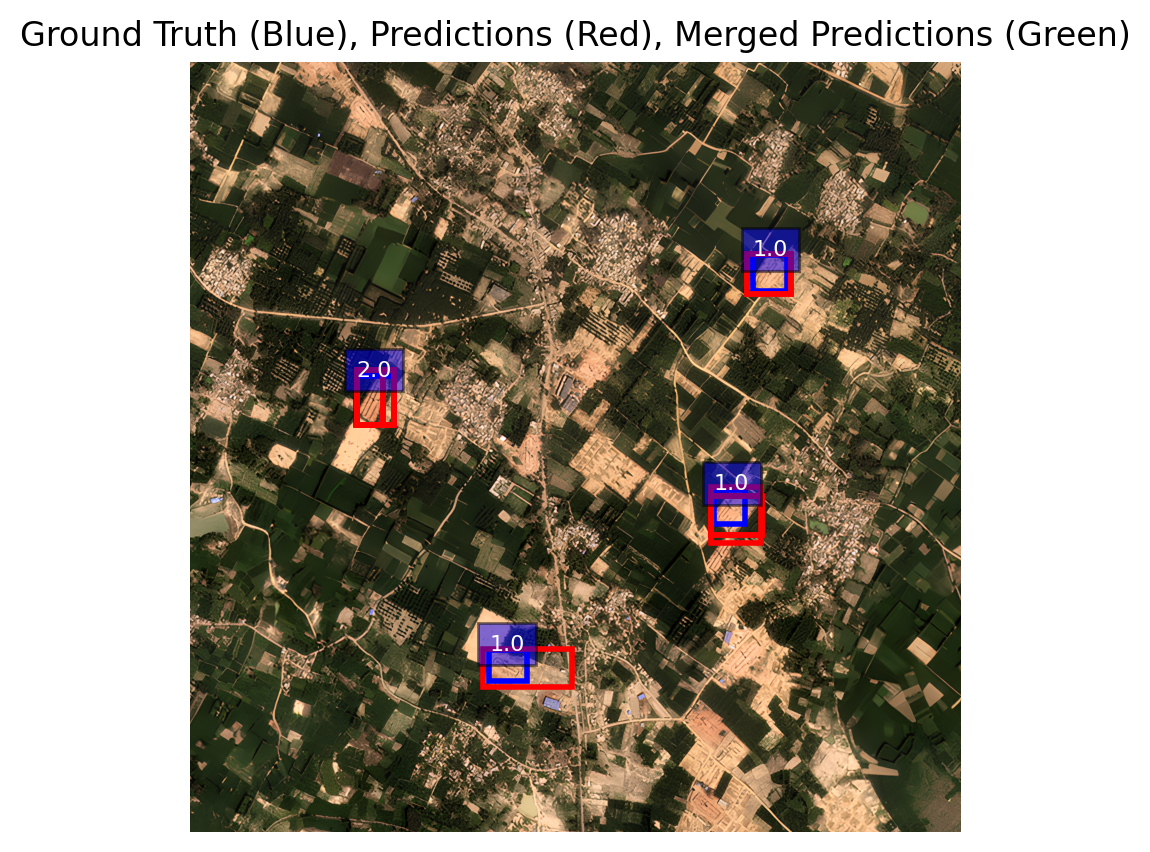

number of ground truth kilns = 12
predicted number of kilns = 134
number of kilns predicted correctly = 10


In [ ]:
# x = slicing.slice_image(
#     image=image_path,
#     slice_height=640,
#     slice_width=640,
#     overlap_height_ratio=0.25,
#     overlap_width_ratio=0.25,
# )
# original_image = Image.open(image_path)
# output_bboxes = []
# output_labels = []
# for i in range(len(x.sliced_image_list)):
#     im = x.sliced_image_list[i]
#     img = Image.fromarray(im.image)
#     inputs = processor(text = text_prompt, images=img, return_tensors="pt").to(device, torch_dtype) # giving input to model
#     generated_ids = model.generate(
#         input_ids=inputs["input_ids"],
#         pixel_values=inputs["pixel_values"],
#         max_new_tokens=4096,
#         num_beams=3,
#         do_sample=False
#     )
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0] # model output
#     od_parsed = processor.post_process_generation(generated_text, task="<CAPTION_TO_PHRASE_GROUNDING>", image_size=(img.width, img.height))
#     # print(od_parsed)
#     model_op = od_parsed["<CAPTION_TO_PHRASE_GROUNDING>"] # relevant portion of model output
#     op_bboxes = model_op['bboxes'] # bounding boxes in [xmin, ymin, xmax, ymax] format
#     op_labels = model_op['labels'] #labels
#     filtered_bboxes = []
#     filtered_labels = []
#     if op_bboxes!=[] and op_labels!=[]:
#         for bbox, label in zip(op_bboxes, op_labels):
#             if label != "satellite image":
#                 filtered_bboxes.append(bbox)
#                 filtered_labels.append(label)
#     print(filtered_bboxes)
#     print(filtered_labels)
#     for bbox in filtered_bboxes:
#         ofs_x, ofs_y = im.starting_pixel
#         x1 = bbox[0] + ofs_x
#         y1 = bbox[1] + ofs_y
#         x2 = bbox[2] + ofs_x
#         y2 = bbox[3] + ofs_y
#         new_bb = [x1, y1, x2, y2]
#         output_bboxes.append(new_bb)
#     output_labels.extend(filtered_labels)
# with open(label_path):
#     gt = np.loadtxt(label_path, ndmin=2)
# gt_bboxes = []
# gt_labels = []
# for gt_kiln in gt:
#     gt_i, gt_lab = convert_to_xyxy(gt_kiln, 2560, 2560)
#     gt_bboxes.append(gt_i)
#     gt_labels.append(gt_lab)

# # pred_bboxes = merge_boxes(output_bboxes) ### add code to give merged predictions
# if len(gt_bboxes) != 0:
#     matched_pairs, kilns_found, gt_kilns_found = match_boxes(output_bboxes, gt_bboxes, iou_th)
# else:
#     matched_pairs = []
#     kilns_found = 0
# gt_num = len(gt_bboxes)
# pred_num = len(output_bboxes)
# num_corr = len(matched_pairs)

# predictions_that_matched = []
# for i in range(len(matched_pairs)):
#     predictions_that_matched.append(matched_pairs[i][0])

# fig, ax = plt.subplots(figsize=(10, 5))  # Single plot
# ax.imshow(original_image)
# for i in range(len(gt_kilns_found)):
#     if gt_kilns_found[i]==1:
#         x1, y1, x2, y2 = gt_bboxes[i]
#         rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='b', facecolor='none')
#         ax.add_patch(rect)
#         if gt_labels:
#             ax.text(x1, y1, gt_labels[i], color='white', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))

    
# for idx, bbox in enumerate(predictions_that_matched):
#     x1, y1, x2, y2 = bbox
#     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

# # for idx, bbox in enumerate(pred_bboxes):
# #     x1, y1, x2, y2 = bbox
# #     rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
# #     ax.add_patch(rect)

# ax.axis("off")
# plt.title("Ground Truth (Blue), Predictions (Red), Merged Predictions (Green)")
# plt.show()

#     # prec = num_corr/pred_num
#     # rec = num_corr/gt_num
#     # f1 = 2/((1/prec)+(1/rec))
# print("number of ground truth kilns =", gt_num)
# print("predicted number of kilns =", pred_num)
# print("number of predictions that were correct =", num_corr)
# print("number of ground truth kilns found by the predictions =", kilns_found)